# Decision Trees on Amazon dataset

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

#### objective:
Apply GridSearchCV to find optimal depth of trees using decision tree classifier   on Amazon dataset

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn import cross_validation
from sklearn.model_selection import train_test_split

In [32]:
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import log_loss

# Loading the data


The dataset is available in two forms

1) .csv file
2)  SQLite Database




In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently. 
Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative"


Also we sort data by time-based slicing

## Loading Preprocessed Data

I have preprocessed the data separately for 250k points and stored in cleanedreviews.csv

In [2]:
df=pd.read_csv('cleanedreviews.csv')
df.head()

,Unnamed: 0,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,witty little book makes son laugh loud recite ...
1,1,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,remember seeing show aired television years ag...
2,2,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,beetlejuice well written movie everything exce...
3,3,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,twist rumplestiskin captured film starring mic...
4,4,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,twist rumplestiskin captured film starring mic...


In [3]:
df['Score'].value_counts()

1    215035
0     34965
Name: Score, dtype: int64

In [4]:
df['Class']=['positive' if s==1 else 'negative' for s in df['Score']]

## Splitting the data in train and test

In [6]:
#array that contains +ve=1 and -ve=0 reviews
y=np.array(sub_data['Score'])

In [7]:
# split the data set into train and test
x_1, x_test, y_1, y_test = cross_validation.train_test_split(sub_data['Text'], y, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
x_tr, x_cv, y_tr, y_cv = cross_validation.train_test_split(x_1, y_1, test_size=0.3,random_state=0)

In [8]:
def plot_confusion_matrix(cm, cls=set(df['Class']),
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(cls))
    plt.xticks(tick_marks, cls, rotation=45)
    plt.yticks(tick_marks, cls)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Word2Vec


In [9]:
# Using Google News Word2Vectors
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [10]:
# Train your own Word2Vec model using your own text corpus
import gensim

In [12]:
w2v_model=gensim.models.Word2Vec(x_tr,min_count=5,size=200, workers=4)    
type(w2v_model)

gensim.models.word2vec.Word2Vec

## AVG Word2Vec

In [13]:
# Function to average all word vectors in a paragraph
def featureVecMethod(words, model, num_features):
    # Pre-initialising empty numpy array for speed
    featureVec = np.zeros(num_features,dtype="float32")
    nwords = 0
    
    #Converting Index2Word which is a list to a set for better speed in the execution.
    index2word_set = set(model.wv.index2word)
    
    for word in  words:
        if word in index2word_set:
            nwords = nwords + 1
            featureVec = np.add(featureVec,model[word])
    
    # Dividing the result by number of words to get average
    featureVec = np.divide(featureVec, nwords)
    return featureVec

In [14]:
# Function for calculating the average feature vector
def getAvgFeatureVecs(reviews, model, num_features):
    counter = 0
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    for review in reviews:
        reviewFeatureVecs[counter] = featureVecMethod(review, model, num_features)
        counter = counter+1
        
    return reviewFeatureVecs

In [15]:
#finding W2V for 200dimensions
trainDataVecs = getAvgFeatureVecs(x_tr, w2v_model, 200)

In [16]:
type(trainDataVecs)

numpy.ndarray

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import cross_val_score

In [18]:
from sklearn.tree import DecisionTreeClassifier


In [19]:
#parameters
tuned_param=[{'max_depth':[10,15,20,25,30,35]}]

### GridSearchCV to Find Optimal depth for decision trees

In [22]:
dt_model=GridSearchCV(DecisionTreeClassifier(),tuned_param,scoring='f1',cv=3)
dt_model.fit(trainDataVecs,y_tr)
dt_model.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### Depth

In [23]:
dt_model.best_params_

{'max_depth': 10}

Optimal depth is 10

In [24]:
#getting Vectorisers for test
testDataVecs = getAvgFeatureVecs(x_test, w2v_model, 200)

In [25]:
#predicting on test data
pred=dt_model.predict(testDataVecs)

## Confusion Matrix

Confusion matrix, without normalization
[[  155  1111]
 [  159 10575]]


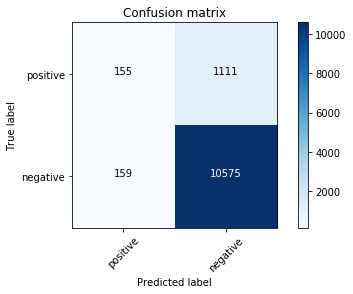

In [27]:
plot_confusion_matrix(confusion_matrix(y_test,pred))

#### Observation:
* True positve=155
* True negative=10575

In [28]:
cvdatavecs=getAvgFeatureVecs(x_cv, w2v_model, 200)

## Plotting CV-error Vs Depth


For values of depth =  1 The log loss is: 0.3447099934222848
For values of depth =  5 The log loss is: 0.35337687786128996
For values of depth =  10 The log loss is: 0.672370912866582
For values of depth =  15 The log loss is: 1.4043085195188623
For values of depth =  20 The log loss is: 2.08312794561568
For values of depth =  25 The log loss is: 3.107643289820601
For values of depth =  30 The log loss is: 3.8763087919295725
For values of depth =  35 The log loss is: 4.504813281863128


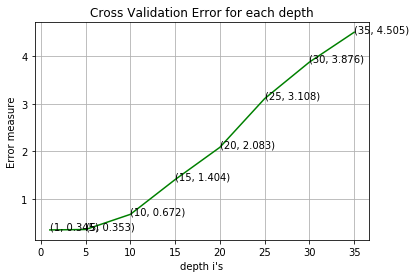

In [33]:
alpha = [1,5,10,15,20,25,30,35]
cv_log_error_array=[]
for i in alpha:
    dt = DecisionTreeClassifier(max_depth=i,random_state=42)
    dt.fit(trainDataVecs, y_tr)
    predict_y = dt.predict_proba(cvdatavecs)
    #finding CV-error
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=dt.classes_, eps=1e-15))
    print('For values of depth = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=dt.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each depth")
plt.xlabel("depth i's")
plt.ylabel("Error measure")
plt.show()


### Observation:
Optimal dept=10;logloss=0.672370912866582

In [38]:
print("test_error:",log_loss(y_test, pred, labels=dt.classes_, eps=1e-15))

test_error: 3.6554278645234604


## Conclusion

Decision Tree Classifier using Avg2vec :
 * depth=10 (GridSearchCV)
 * CV_logloss=0.672370912866582
 * Test_logloss=3.65547
